# Deep Earth PREM: The effect of ICB radius on the Earth's inertia coefficient (I/MR<sup>2</sup>)

In computing PREM, one of the constraints that Dziewonski and Anderson satisfied was the inertia coefficient of the Earth, given as $I/MR^2=0.3308$ (without errors).  Here we can test the effect on the inertia coefficient of changing the ICB radius.

To do the calculations, we need to import a few things.

In [1]:
using SeisModels
import Plots
using Plots: plot, plot!, hline!, vline!, scatter, scatter!

These two above give us access to the seismic models module, `SeisModels` (see the [documentation](https://anowacki.github.io/SeisModels.jl/stable/) for more information) and [Plots](http://docs.juliaplots.org/latest/) to make figures.

In [2]:
using Measurements
using Measurements: value, uncertainty
using Unitful: kg, km, m

These packages allow us to deal with errors and units easily.

## Earth reference values and uncertainties

The current reference values for the Earth have changed a small amount from those used in making PREM.  The following are taken from Chambat & Valette (PEPI, 2001):

In [3]:
M = (5.9733 ± 0.0090).*1e24*kg # Earth's mass
R = (6_370_994.4 ± 3.0)*m # Earth's reference radius
I = (8.018 ± 0.012).*1e13*m^2*kg # Moment of interia
I_MR² = 0.330714 ± 0.000008 # Inertia coefficient

0.330714 ± 8.0e-6

### Comparing inertia coefficient as the ICB radius changes

First of all, let's define a function to compute the inertia coefficient for a `SeisModel`.  (Note that in Julia, the last evaluated expression is returned, so this does indeed return $I/MR^2$.)

In [4]:
"Compute the inertia coefficient, I/MR², for a `SeisModel`."
function inertia_coefficient(m::SeisModel)
    R = surface_radius(m) # km
    I = moment_of_inertia(m) # kg⋅m²
    M = mass(m, R) # kg
    I/(M*(1e3*R)^2) # Convert radius to m
end

inertia_coefficient

Now, we can find out what the inertia coefficient is whilst changing the ICB radius 500 km either way from PREM's value.  This will have an effect because the density of the inner core is higher.

With `SeisModels`, the easiest way is to create a copy of the `PREM` inbuilt model and perturb the radius of the ICB in the copy and record the inertia coefficient.

In PREM, the inner core is the first layer of the model, so we can vary the radius of the first layer in our copy of PREM, prem$'$ by changing the value of `prem′.r[1]`. 

In [5]:
prem′ = deepcopy(PREM)
prem_r_icb = PREM.r[1]
r_icb = prem_r_icb .+ (-500:500)
icoeffs = zeros(length(r_icb))
for (i, r) in enumerate(r_icb)
    prem′.r[1] = r
    icoeffs[i] = inertia_coefficient(prem′)
end

(In Julia, you can usually type symbols in like you would in LaTeX math mode and pressing `<tab>`, so for `prem′` type `prem\prime` and then hit `<tab>`, or for ² type `\^2<tab>`; this works in Jupyter notebooks too.)

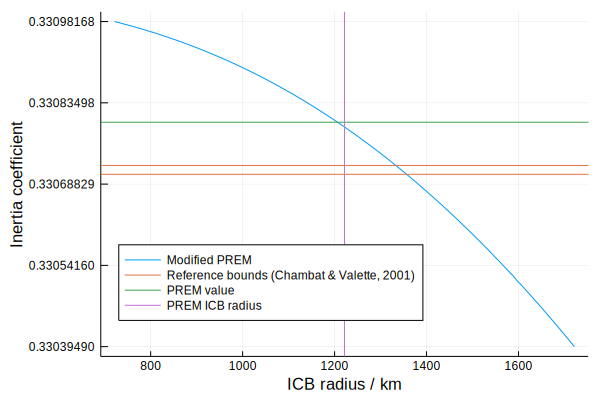

In [6]:
# Help GR with y-axis ticks
ticks = range(minimum(icoeffs), stop=maximum(icoeffs), length=5)
plot(r_icb, icoeffs, xlabel="ICB radius / km", ylabel="Inertia coefficient",
    legend=:bottomleft, yticks=ticks, label="Modified PREM")
hline!([value(I_MR²) - uncertainty(I_MR²), value(I_MR²) + uncertainty(I_MR²)],
    label="Reference bounds (Chambat & Valette, 2001)")
hline!([0.3308], label="PREM value")
vline!([prem_r_icb], label="PREM ICB radius")

What is the best fitting ICB radius to satisfy the modern $I/MR^2$ constraint?

In [7]:
icb_r_best = r_icb[argmin(abs.(value(I_MR²) .- icoeffs))]

1344.5

What does this model look like?  We haven't changed the polynomial coefficients representing the inner and outer core at all, only the radius over which they are evaluated.

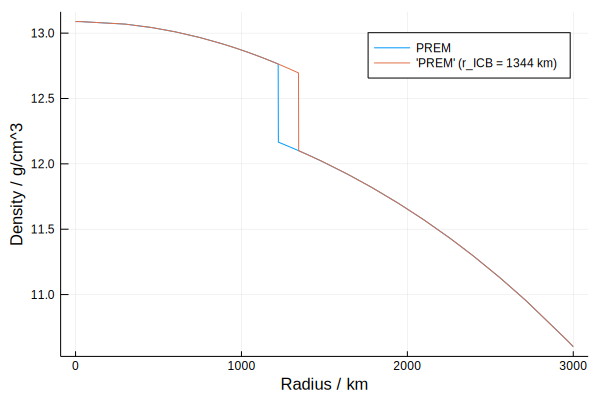

In [8]:
prem′.r[1] = icb_r_best # Model with 'best' ICB radius
plot(r -> density(PREM, r), 0, 3000, label="PREM",
    xlabel="Radius / km", ylabel="Density / g/cm^3")
plot!(r -> density(prem′, r), 0, 3000,
    label="'PREM' (r_ICB = $(round(Int, icb_r_best)) km)")

So, PREM satisfies its own constraints on the inertia coefficient, but more modern constraints on $I/MR^2$ would be a bit different.  If all you did was make PREM's inner core bigger by about 130 km, this would be fine... but then other things might start to go wrong...  For instance, the density and velocity jumps at the ICB would be different, and perhaps the total mass might go off too.

Let's check what happens to the total mass with our new ideal ICB radius:

In [9]:
mass_icb_best = mass(prem′, 0, depth=true)*kg

5.974548143153812e24 kg

In [10]:
value(M) - uncertainty(M) <= mass_icb_best <= value(M) + uncertainty(M)

true

So we can still satisfy the total mass.  But as for seismic travel times and normal mode frequencies?  That's another story...

---
# Normal mode eigenfrequencies


Let's calculate how the eigenfrequencies are affected by changing the ICB.

In [11]:
using Mineos

PREM includes data from normals modes with $n \le 34$ and $\ell \le 165$.  We can calculate all these mode eigenfrequencies for our two models, `PREM` and `prem′`, using the `eigenfrequencies` function from `Mineos`.  Note we need to convert our models—which are parameterised by polynomials—into into `LinearLayeredModel`s, as this is what the Mineos program needs.

In [12]:
freq, freq′ = eigenfrequencies.(LinearLayeredModel.((PREM, prem′)), nmax=34, lmax=165)

┌ Warning: Rayleigh quotient greater than 10*eps for 0T2
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 0T3
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 0T4
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 0T5
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 0T6
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 0T10
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 0T11
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 0T12
└ @ Mineos /Users/nowacki/.jul

┌ Warning: Rayleigh quotient greater than 10*eps for 27C133
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 27C134
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 27C135
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 27C136
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 27C137
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 27C138
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 27C139
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 27C140
└ @ Mineo

┌ Warning: Rayleigh quotient greater than 10*eps for 29C127
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 29C128
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 29C129
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 29C130
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 29C131
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 29C132
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 29C133
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 29C134
└ @ Mineo

┌ Warning: Rayleigh quotient greater than 10*eps for 30C159
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 30C160
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 30C161
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 30C162
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 30C163
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 30C164
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 30C165
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 31C116
└ @ Mineo

┌ Warning: Rayleigh quotient greater than 10*eps for 32C130
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 32C131
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 32C132
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 32C133
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 32C134
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 32C135
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 32C136
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 32C137
└ @ Mineo

┌ Warning: Rayleigh quotient greater than 10*eps for 33C145
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 33C146
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 33C147
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 33C148
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 33C149
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 33C150
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 33C151
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 33C152
└ @ Mineo

┌ Warning: Rayleigh quotient greater than 10*eps for 34C155
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 34C156
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 34C157
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 34C158
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 34C159
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 34C160
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 34C161
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 34C162
└ @ Mineo

┌ Warning: Rayleigh quotient greater than 10*eps for 31C163
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 31C164
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 31C165
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 32C136
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 32C137
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 32C138
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 32C139
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 32C140
└ @ Mineo

┌ Warning: Rayleigh quotient greater than 10*eps for 34C131
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 34C132
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 34C133
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 34C134
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 34C135
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 34C136
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 34C137
└ @ Mineos /Users/nowacki/.julia/packages/Mineos/Kmhk3/src/Mineos.jl:188
┌ Warning: Rayleigh quotient greater than 10*eps for 34C138
└ @ Mineo

(OrderedCollections.OrderedDict((0, :S, 0) => 0.8143385,(1, :S, 0) => 1.631381,(2, :S, 0) => 2.510569,(3, :S, 0) => 3.271285,(4, :S, 0) => 4.105874,(5, :S, 0) => 4.884277,(6, :S, 0) => 5.740338,(7, :S, 0) => 6.580799,(8, :S, 0) => 7.424226,(9, :S, 0) => 8.262776…), OrderedCollections.OrderedDict((0, :S, 0) => 0.8143882,(1, :S, 0) => 1.631913,(2, :S, 0) => 2.51075,(3, :S, 0) => 3.271899,(4, :S, 0) => 4.110913,(5, :S, 0) => 4.896589,(6, :S, 0) => 5.759645,(7, :S, 0) => 6.595293,(8, :S, 0) => 7.425761,(9, :S, 0) => 8.257141…))

The output from our calculation is given in mHz, whilst the PREM data tables show their eigenfrequencies as periods in s.

The data tables in PREM list mode eigenperiods in s, so let's write a little helper function to do the conversion from mHz.

In [13]:
"Convert a frequency in mHz to a period in s"
mHz2s(f) = 1000/f

mHz2s

We can calculate the period of the fundamental radial mode $_0S_0$ for the 'real' and 'best ICB' PREM and compare:

In [14]:
(x -> x[0,:S,0]).((freq, freq′)) .|> mHz2s

(1227.990571488392, 1227.915630408201)

So there is a difference in $_0S_0$ of only $\sim$0.08 s.  Table V in the paper lists PREM as giving $T=1228.02~$s, so that agrees only to 0.003 s with our computation—which perhaps gives an idea about the numerical accuracy of their and our codes!  So the difference between the models isn't so great for this mode.

Let's see which modes are most affected by changing the ICB radius like we have.  We define a function to create a plot where colour shows the relative shift in eigenfrequency on a grid of $l$ versus $n$.

In [15]:
"Plot a grid of eigenfrequencies, where the x-axis is n and the y-axis
is l, shown by colour.  `kwargs...` are passed to the `Plots.scatter`
command."
function plot_diff_eigenfrequencies(f1, f2; type=:S, kwargs...)
    n = Float64[]
    l = similar(n)
    Δf = similar(l)
    for (key, v1) in f1
        nn, s_or_t, ll = key
        s_or_t == type || continue
        push!(n, nn)
        push!(l, ll)
        v2 = f2[key]
        push!(Δf, 2*(v1 - v2)/(v1 + v2))
    end
    scatter(n, l; zcolor=Δf, xlabel="Radial order n", ylabel="Angular order l",
                m=Plots.stroke(0), framestyle=:box, kwargs...)
end

plot_diff_eigenfrequencies

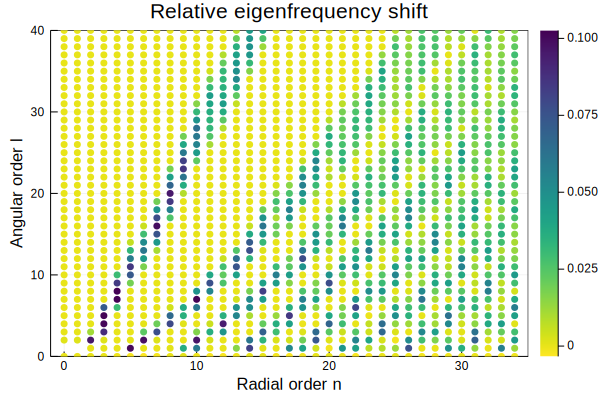

In [16]:
plot_diff_eigenfrequencies(freq, freq′, ylim=(0,40), legend=false,
    colorbar=true, c=:viridis_r, title="Relative eigenfrequency shift")

Looking at the plot and Table V, there are many modes which should show large deviations but which aren't included in PREM (for whatever reason).  However, many are.  Let's take as an example $_6S_{15}$, which is listed as being observed at 178.76 ± 0.07 s.

In [17]:
mode = (6,:S,:15)
mHz2s.((freq[mode], freq′[mode]))

(178.49426167722848, 183.70759776045742)

Even though PREM itself doesn't quite satisfy these data within the data uncertainty, we clearly do a terribe job on this mode if we increase the ICB radius as much as we have.